In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

# Load Data

In [5]:
data = pd.read_csv('./data_identificada.csv').drop(['index','Name','Second_Protocol', 'Third_Protocol'], axis = 1)
data.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,400,TCP,0.0,0.0,9.04175,4287.992,65.519,0.0,6750,360512,...,53.0,80.0,1.0,1.0,5.5,32.0,33.0,873.0,not_mine,Does not have


# Preprocesamiento

### Imputación de valores ausentes

In [6]:
punter = pd.concat([data['second_sp'],data['second_dp'],data['third_sp'],data['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [7]:
punter = pd.DataFrame(values, columns = punter.columns)
data['second_sp'] = punter['second_sp']
data['second_dp'] = punter['second_dp']
data['third_sp'] = punter['third_sp']
data['third_dp'] = punter['third_dp']

### OneHotEncoder

In [8]:
data_categoric = data[data.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<4733x12 sparse matrix of type '<class 'numpy.float64'>'
	with 14199 stored elements in Compressed Sparse Row format>

In [9]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
0,0,0,1,0,0,1,0,0,1,0,0,0
1,0,0,0,1,0,1,0,0,1,0,0,0


### Estructuración

In [10]:
data = data.drop(data_categoric, axis = 1)
data.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib'],
      dtype='object')

In [11]:
data = pd.concat([data,data_dummy], axis = 1)
data.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'Type_not_mine',
       'Cryptocurrency_Bitcash', 'Cryptocurrency_Bitcoin',
       'Cryptocurrency_Does not have', 'Cryptocurrency_Etherium',
       'Cryptocurrency_Litecoin', 'Cryptocurrency_Monero'],
      dtype='object')

# Árboles de decisión

In [12]:
data.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'Type_not_mine',
       'Cryptocurrency_Bitcash', 'Cryptocurrency_Bitcoin',
       'Cryptocurrency_Does not have', 'Cryptocurrency_Etherium',
       'Cryptocurrency_Litecoin', 'Cryptocurrency_Monero'],
      dtype='object')

In [14]:
best_feature_sel = ['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d','p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp','second_sp']

In [15]:
X = data[best_feature_sel]
y = data['Type_mine']

### Holdout

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state = 1234)

In [188]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [189]:
model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Profundidad del árbol: 4
Número de nodos terminales: 5


[Text(159.42857142857142, 489.24, 'first_sp <= 1887.5\nsamples = 3313\nvalue = [1738, 1575]\nclass = T'),
 Text(79.71428571428571, 380.52000000000004, 'samples = 1711\nvalue = [1711, 0]\nclass = T'),
 Text(239.1428571428571, 380.52000000000004, 'second_sp <= 1887.5\nsamples = 1602\nvalue = [27, 1575]\nclass = i'),
 Text(159.42857142857142, 271.8, 'samples = 23\nvalue = [23, 0]\nclass = T'),
 Text(318.85714285714283, 271.8, 'first_dp <= 2616.0\nsamples = 1579\nvalue = [4, 1575]\nclass = i'),
 Text(239.1428571428571, 163.08000000000004, 'samples = 3\nvalue = [3, 0]\nclass = T'),
 Text(398.57142857142856, 163.08000000000004, '#dp <= 5.5\nsamples = 1576\nvalue = [1, 1575]\nclass = i'),
 Text(318.85714285714283, 54.360000000000014, 'samples = 1575\nvalue = [0, 1575]\nclass = i'),
 Text(478.2857142857142, 54.360000000000014, 'samples = 1\nvalue = [1, 0]\nclass = T')]

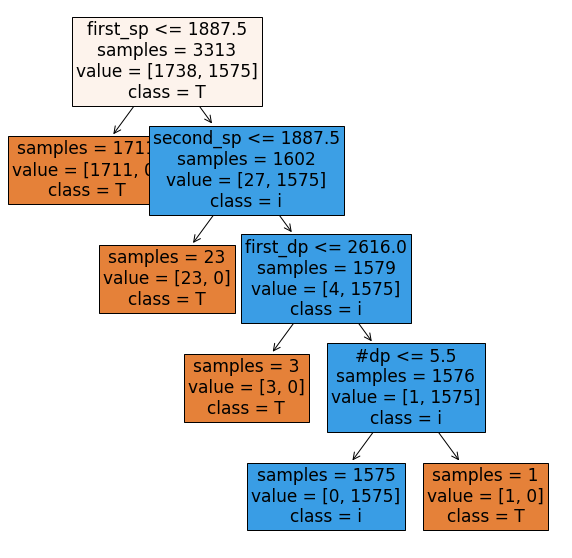

In [190]:
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [191]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=uint8)

In [192]:
len(y_pred[y_pred == 0])

763

In [193]:
len(y_pred[y_pred == 1])

657

# Métricas y matriz de confusión

([<matplotlib.axis.YTick at 0x17f312429e8>,
 <a list of 2 Text yticklabel objects>)

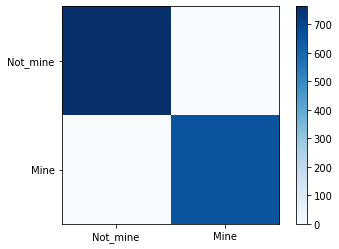

In [194]:
churm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(churm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [195]:
pd.DataFrame(churm)

,0,1
0,763,0
1,0,657


In [196]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa: ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  1.0
Kappa:  1.0


In [197]:
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[1], average='macro'))

VP = np.sum(churm[1:2,1:2])
FN = np.sum(churm[1,0:1])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[1], average='macro'))

Precisión     :  1.0
Recall        :  1.0
Especificidad :  1.0
F1-score      :  1.0


In [198]:
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[0], average='macro'))

VP = np.sum(churm[0:1,0:1])
FN = np.sum(churm[0,1:2])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[0], average='macro'))

Precisión     :  1.0
Recall        :  1.0
Especificidad :  1.0
F1-score      :  1.0


In [199]:
y_pred_proba = model.predict_proba(X_test)

In [200]:
lr_probs = y_pred_proba[:,1]

In [201]:
ns_probs = [0 for _ in range(len(y_test))]

In [202]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

0.5

In [203]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

1.0

In [204]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Treeb: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Treeb: ROC AUC=1.000


In [205]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

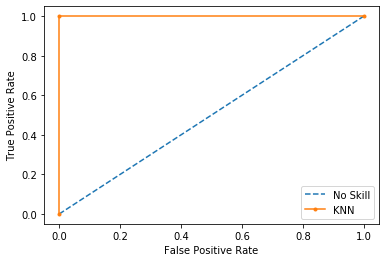

In [206]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Holdaunt 70% pero debo hacer una validadci{on cruzada en este conjunto de entrenamiento (Puros), de este cruz validation saldra un modelo, y lo testeo con el 30%, con este porcentaje, le saco las metricas

# Exprimento 1

In [207]:
data_N = pd.read_csv('./data_no_identificada.csv')
data_N.columns

Index(['index', 'Name', 'Netflows', 'First_Protocol', 'Second_Protocol',
       'Third_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'Type', 'Cryptocurrency'],
      dtype='object')

In [208]:
Feature_Selection =['p1_d', 'p2_d', 'min_d', '#sp', '#dp', 'first_sp', 'first_dp', 'second_sp', 'second_dp','Type']

In [209]:
temp = data_N[Feature_Selection]

In [210]:
temp = temp.dropna()

In [211]:
temp.isnull().sum()

p1_d         0
p2_d         0
min_d        0
#sp          0
#dp          0
first_sp     0
first_dp     0
second_sp    0
second_dp    0
Type         0
dtype: int64

In [212]:
y_predN = model.predict(temp.drop('Type', axis = 1))
y_predN

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [213]:
len(y_predN[y_predN == 0])

31703

In [214]:
len(y_predN[y_predN == 1])

295

In [215]:
y_tesN = temp['Type'].replace({'mine':1,'not_mine':0})

([<matplotlib.axis.YTick at 0x17f31f560b8>,
 <a list of 2 Text yticklabel objects>)

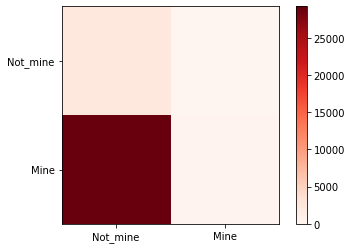

In [253]:
churm = metrics.confusion_matrix(y_tesN, y_predN)
plt.imshow(churm, cmap=plt.cm.Reds)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [217]:
pd.DataFrame(churm)

,0,1
0,2498,0
1,29205,295


In [218]:
print("Exactitud: ", metrics.accuracy_score(y_tesN, y_predN))
print("Kappa: ", metrics.cohen_kappa_score(y_tesN, y_predN))

Exactitud:  0.08728670541908869
Kappa:  0.0015746353849189765


In [219]:
print("Precisión     : ", metrics.precision_score(y_tesN, y_predN, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_tesN, y_predN, labels=[1], average='macro'))

VP = np.sum(churm[1:2,1:2])
FN = np.sum(churm[1,0:1])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_tesN, y_predN, labels=[1], average='macro'))

Precisión     :  1.0
Recall        :  0.01
Especificidad :  0.01
F1-score      :  0.019801980198019802


In [220]:
print("Precisión     : ", metrics.precision_score(y_tesN, y_predN, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_tesN, y_predN, labels=[0], average='macro'))

VP = np.sum(churm[0:1,0:1])
FN = np.sum(churm[0,1:2])
specificity = VP/(VP+FN)
print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_tesN, y_predN, labels=[0], average='macro'))

Precisión     :  0.07879380500268113
Recall        :  1.0
Especificidad :  1.0
F1-score      :  0.14607760007017337


# Experimento 2

In [221]:
Feature_Selection = ['p1_d', 'p2_d','min_d','#sp','#dp','first_sp', 'first_dp', 'second_sp','second_dp']
X = data[Feature_Selection]
y = data['Type_mine']

In [222]:
X_train, X_validate, y_train, y_validate = train_test_split(X,y, train_size = 0.7)

In [223]:
X_train_II, X_test_II, y_train_II, y_test_II = train_test_split(X_train, y_train, train_size = 0.7)

In [224]:
model_II = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [225]:
model_II.fit(X_train_II,y_train_II)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Profundidad del árbol: 4
Número de nodos terminales: 5


[Text(186.0, 475.65000000000003, 'first_sp <= 1887.5\nsamples = 2319\nvalue = [1258, 1061]\nclass = T'),
 Text(93.0, 339.75, 'samples = 1242\nvalue = [1242, 0]\nclass = T'),
 Text(279.0, 339.75, 'second_dp <= 2616.0\nsamples = 1077\nvalue = [16, 1061]\nclass = i'),
 Text(186.0, 203.85000000000002, 'samples = 15\nvalue = [15, 0]\nclass = T'),
 Text(372.0, 203.85000000000002, 'first_dp <= 1692.5\nsamples = 1062\nvalue = [1, 1061]\nclass = i'),
 Text(279.0, 67.94999999999999, 'samples = 1\nvalue = [1, 0]\nclass = T'),
 Text(465.0, 67.94999999999999, 'samples = 1061\nvalue = [0, 1061]\nclass = i')]

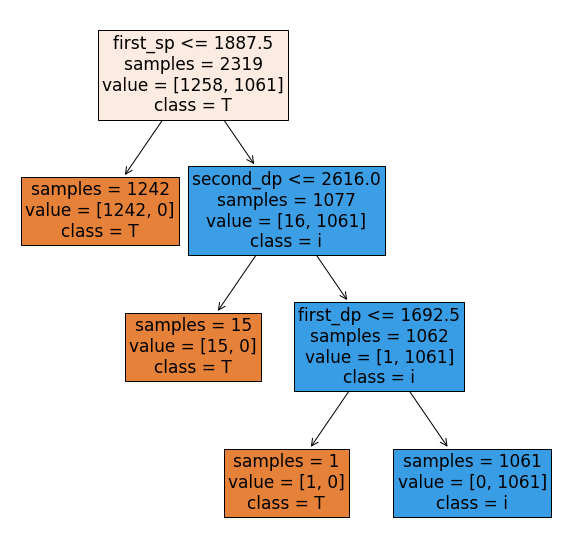

In [226]:
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model_II,
    feature_names = X_train_II.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [227]:
y_pred_II = model_II.predict(X_test_II)

# Métricas y matriz de confusión modelo II

([<matplotlib.axis.YTick at 0x17f31ffcda0>,
 <a list of 2 Text yticklabel objects>)

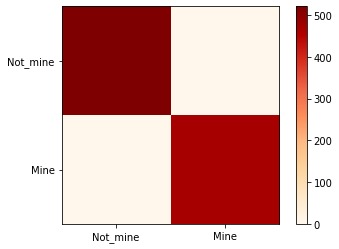

In [254]:
churm = metrics.confusion_matrix(y_test_II, y_pred_II)
plt.imshow(churm, cmap=plt.cm.OrRd)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [229]:
pd.DataFrame(churm)

,0,1
0,521,2
1,0,471


In [230]:
print("Exactitud: ", metrics.accuracy_score(y_test_II, y_pred_II))
print("Kappa: ", metrics.cohen_kappa_score(y_test_II, y_pred_II))

Exactitud:  0.9979879275653923
Kappa:  0.9959656634941251


In [231]:
print("Precisión     : ", metrics.precision_score(y_test_II, y_pred_II, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_test_II, y_pred_II, labels=[1], average='macro'))

VP = np.sum(churm[1:2,1:2])
FN = np.sum(churm[1,0:1])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test_II, y_pred_II, labels=[1], average='macro'))

Precisión     :  0.9957716701902748
Recall        :  1.0
Especificidad :  1.0
F1-score      :  0.9978813559322034


In [232]:
print("Precisión     : ", metrics.precision_score(y_test_II, y_pred_II, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_test_II, y_pred_II, labels=[0], average='macro'))

VP = np.sum(churm[0:1,0:1])
FN = np.sum(churm[0,1:2])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test_II, y_pred_II, labels=[0], average='macro'))

Precisión     :  1.0
Recall        :  0.9961759082217974
Especificidad :  0.9961759082217974
F1-score      :  0.9980842911877394


In [246]:
predict_validate = model_II.predict(X_validate)

([<matplotlib.axis.YTick at 0x17f31ef2668>,
 <a list of 2 Text yticklabel objects>)

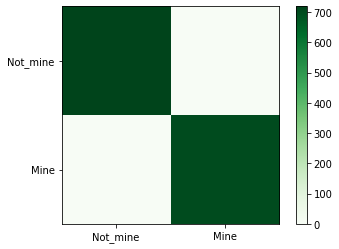

In [251]:
churm = metrics.confusion_matrix(y_validate, predict_validate)
plt.imshow(churm, cmap=plt.cm.Greens)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [252]:
pd.DataFrame(churm)

,0,1
0,719,1
1,0,700


In [244]:
model_III = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [245]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model_III, X_validate, y_validate, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))

fit_time: 0.01 (+/- 0.00)
score_time: 0.02 (+/- 0.02)
test_accuracy: 1.00 (+/- 0.01)
test_precision_weighted: 1.00 (+/- 0.01)
test_recall_weighted: 1.00 (+/- 0.01)
test_f1_weighted: 1.00 (+/- 0.01)


In [260]:
data_N['Type'].value_counts()

mine        37053
not_mine     2501
Name: Type, dtype: int64

In [269]:
data_N_Mineros = data_N[data_N.Type == 'mine']
data_N_NoMineros = data_N.sample(n=2501)

In [294]:
data = pd.read_csv('./data_identificada.csv')
data_combinada = pd.concat([data_N_Mineros,data_N_NoMineros,data],axis = 0)
data_combinada

,index,Name,Netflows,First_Protocol,Second_Protocol,Third_Protocol,p1_d,p2_d,p3_d,duration,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,36016,20-csves/8177.csv,17,UDP,ICMP6,NaN,0.00000,3.0010,360.02400,2790.015,...,1900.0,17500.0,1.00,2.0,4.00,32.00,500.0,700.00,mine,Unidentified
1,12659,18-csves/5102.csv,28,ICMP6,ICMP,UDP,0.00000,0.0000,0.00000,13.505,...,1281.0,5353.0,1.00,1.0,1.00,32.00,32.0,40.00,mine,Unidentified
2,8388,18-csves/831.csv,18,ICMP6,ICMP,UDP,0.00000,0.0000,0.00000,556.202,...,1281.0,45560.0,1.00,1.0,1.00,32.00,36.0,250.50,mine,Unidentified
3,16127,18-csves/8570.csv,28,ICMP6,ICMP,TCP,0.00000,0.0000,0.00000,1021.895,...,1281.0,45560.0,1.00,1.0,1.00,32.00,32.0,66.00,mine,Unidentified
4,23859,19-csves/6208.csv,30,ICMP6,ICMP,UDP,0.00000,0.0000,0.00000,1080.234,...,1281.0,5353.0,1.00,1.0,1.00,32.00,32.0,43.75,mine,Unidentified
5,16675,18-csves/9118.csv,32,ICMP6,ICMP,TCP,0.00000,0.0000,0.00000,683.281,...,1281.0,45560.0,1.00,1.0,1.00,32.00,32.0,157.00,mine,Unidentified
6,23582,19-csves/5931.csv,25,ICMP6,ICMP,TCP,0.00000,0.0000,0.00000,988.991,...,1281.0,3333.0,1.00,1.0,1.00,32.00,32.0,40.00,mine,Unidentified
7,15996,18-csves/8439.csv,29,ICMP6,ICMP,TCP,0.00000,0.0000,0.00000,238.605,...,1281.0,49604.0,1.00,1.0,1.00,32.00,32.0,40.00,mine,Unidentified
8,23672,19-csves/6021.csv,25,ICMP6,ICMP,UDP,0.00000,0.0000,0.00000,563.872,...,1281.0,5353.0,1.00,1.0,1.00,32.00,32.0,45.00,mine,Unidentified
9,35694,20-csves/7855.csv,17,ICMP6,NaN,NaN,0.00000,0.0000,0.00000,0.000,...,34304.0,NaN,1.00,1.0,1.00,32.00,32.0,32.00,mine,Unidentified


In [295]:
import random

data_combinada = data_combinada.reset_index()
indices = list(data_combinada.index)
random.shuffle(indices)

In [296]:
data_combinada = data_combinada.reindex(indices)
data_combinada.head()

,level_0,index,Name,Netflows,First_Protocol,Second_Protocol,Third_Protocol,p1_d,p2_d,p3_d,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
15635,16685,9559,18-csves/2002.csv,23,ICMP6,ICMP,TCP,0.0,0.0,0.0,...,1281.0,49604.0,1.0,1.0,1.0,32.0,32.0,40.0,mine,Unidentified
30000,32017,8664,18-csves/1107.csv,22,ICMP6,ICMP,NaN,0.0,0.0,0.0,...,1281.0,34304.0,1.0,1.0,1.0,32.0,32.0,32.0,mine,Unidentified
29763,31769,6473,17-csves/1457.csv,17,ICMP6,ICMP,TCP,0.0,0.0,0.0,...,8084.0,1281.0,1.0,1.0,1.0,32.0,52.0,92.0,mine,Unidentified
28791,30720,26848,19-csves/9197.csv,21,ICMP6,ICMP,UDP,0.0,0.0,0.0,...,1281.0,547.0,1.0,1.0,1.0,32.0,32.0,40.0,mine,Unidentified
35421,37818,31660,20-csves/3821.csv,31,ICMP6,UDP,NaN,0.0,0.0,0.0,...,34816.0,34304.0,1.0,1.0,1.0,32.0,32.0,32.0,mine,Unidentified


In [289]:
feature_selection = ['p1_d', 'p2_d','min_d','#sp','#dp','duration','first_sp', 'first_dp', 'second_sp','second_dp','Avg_bps', 'Avg_pps', 'Avg_bpp','p2_ip','Type']

In [297]:
data_combinada.columns

Index(['level_0', 'index', 'Name', 'Netflows', 'First_Protocol',
       'Second_Protocol', 'Third_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type', 'Cryptocurrency'],
      dtype='object')

In [298]:
data_combinada = data_combinada[feature_selection]

In [315]:
data_combinada.isnull().sum()

p1_d         0
p2_d         0
min_d        0
#sp          0
#dp          0
duration     0
first_sp     0
first_dp     0
second_sp    0
second_dp    0
Avg_bps      0
Avg_pps      0
Avg_bpp      0
p2_ip        0
Type         0
dtype: int64

In [310]:
punter = pd.concat([data_combinada['second_sp'],data_combinada['second_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [314]:
unter = pd.DataFrame(values, columns = punter.columns)
data_combinada['second_sp'] = unter['second_sp']
data_combinada['second_dp'] = unter['second_dp']

In [316]:
data_categoric = data_combinada[data_combinada.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<44287x2 sparse matrix of type '<class 'numpy.float64'>'
	with 44287 stored elements in Compressed Sparse Row format>

In [317]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,Type_mine,Type_not_mine
15635,1,0
30000,1,0


In [319]:
data_combinada = data_combinada.drop(data_categoric, axis = 1)
data_combinada.columns

Index(['p1_d', 'p2_d', 'min_d', '#sp', '#dp', 'duration', 'first_sp',
       'first_dp', 'second_sp', 'second_dp', 'Avg_bps', 'Avg_pps', 'Avg_bpp',
       'p2_ip'],
      dtype='object')

In [320]:
data_combinada = pd.concat([data_combinada,data_dummy], axis = 1)
data_combinada.columns

Index(['p1_d', 'p2_d', 'min_d', '#sp', '#dp', 'duration', 'first_sp',
       'first_dp', 'second_sp', 'second_dp', 'Avg_bps', 'Avg_pps', 'Avg_bpp',
       'p2_ip', 'Type_mine', 'Type_not_mine'],
      dtype='object')

In [324]:
feature_selection = ['p1_d', 'p2_d','min_d','#sp','#dp','duration','first_sp', 'first_dp', 'second_sp','second_dp','Avg_bps', 'Avg_pps', 'Avg_bpp','p2_ip']

In [325]:
X = data_combinada[Feature_Selection]
y = data_combinada['Type_mine']

In [346]:
X_train, X_validate, y_train, y_validate = train_test_split(X,y, train_size = 0.7)
X_trainII, X_testII, y_trainII, y_testII = train_test_split(X_train,y_train, train_size = 0.7)

In [348]:
model_combinado = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [349]:
model_combinado.fit(X_trainII,y_trainII)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Profundidad del árbol: 5
Número de nodos terminales: 24


[Text(330.90697674418607, 498.3, 'first_dp <= 445.0\nsamples = 21700\nvalue = [1312, 20388]\nclass = i'),
 Text(204.38372093023256, 407.70000000000005, 'first_sp <= 74.0\nsamples = 1484\nvalue = [1261, 223]\nclass = T'),
 Text(103.81395348837209, 317.1, '#dp <= 149.0\nsamples = 409\nvalue = [203, 206]\nclass = i'),
 Text(51.906976744186046, 226.5, 'first_dp <= 60.0\nsamples = 213\nvalue = [181, 32]\nclass = T'),
 Text(25.953488372093023, 135.89999999999998, 'first_sp <= 26.5\nsamples = 192\nvalue = [180, 12]\nclass = T'),
 Text(12.976744186046512, 45.299999999999955, 'samples = 4\nvalue = [0, 4]\nclass = i'),
 Text(38.93023255813954, 45.299999999999955, 'samples = 188\nvalue = [180, 8]\nclass = T'),
 Text(77.86046511627907, 135.89999999999998, '#sp <= 24.0\nsamples = 21\nvalue = [1, 20]\nclass = i'),
 Text(64.88372093023256, 45.299999999999955, 'samples = 20\nvalue = [0, 20]\nclass = i'),
 Text(90.83720930232558, 45.299999999999955, 'samples = 1\nvalue = [1, 0]\nclass = T'),
 Text(155.

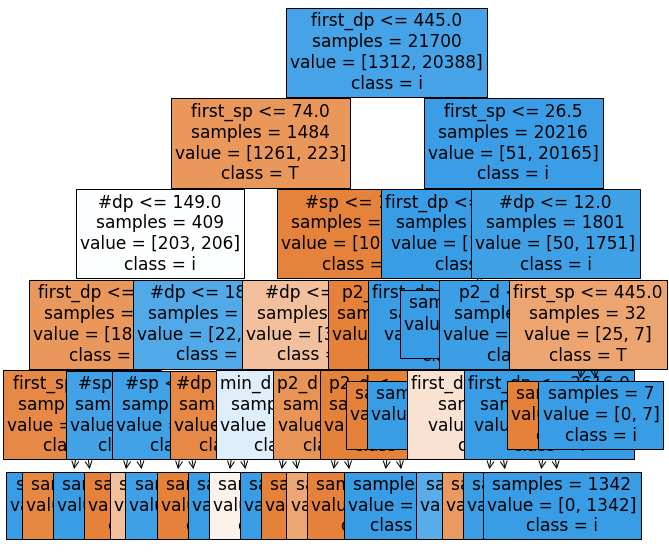

In [350]:
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model_combinado.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model_combinado.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model_combinado,
    feature_names = X_trainII.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [351]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model_combinado, X_validate, y_validate, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))

fit_time: 0.05 (+/- 0.02)
score_time: 0.03 (+/- 0.02)
test_accuracy: 1.00 (+/- 0.00)
test_precision_weighted: 1.00 (+/- 0.00)
test_recall_weighted: 1.00 (+/- 0.00)
test_f1_weighted: 1.00 (+/- 0.00)


In [352]:
predict_validate = model_combinado.predict(X_validate)

([<matplotlib.axis.YTick at 0x17f37036438>,
 <a list of 2 Text yticklabel objects>)

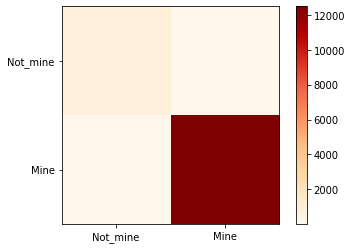

In [353]:
churm = metrics.confusion_matrix(y_validate, predict_validate)
plt.imshow(churm, cmap=plt.cm.OrRd)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [345]:
pd.DataFrame(churm)

,0,1
0,737,13
1,19,12518


In [344]:
print("Exactitud: ", metrics.accuracy_score(y_validate, predict_validate))
print("Kappa: ", metrics.cohen_kappa_score(y_validate, predict_validate))

Exactitud:  0.9975916309174381
Kappa:  0.9774751536615749


In [343]:
print("Precisión     : ", metrics.precision_score(y_validate, predict_validate, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_validate, predict_validate, labels=[1], average='macro'))

VP = np.sum(churm[1:2,1:2])
FN = np.sum(churm[1,0:1])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_validate, predict_validate, labels=[1], average='macro'))

Precisión     :  0.9989625728194079
Recall        :  0.9984844859216718
Especificidad :  0.9984844859216718
F1-score      :  0.9987234721557364


In [342]:
print("Precisión     : ", metrics.precision_score(y_validate, predict_validate, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_validate, predict_validate, labels=[0], average='macro'))

VP = np.sum(churm[0:1,0:1])
FN = np.sum(churm[0,1:2])
specificity = VP/(VP+FN)
print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_validate, predict_validate, labels=[0], average='macro'))

Precisión     :  0.9748677248677249
Recall        :  0.9826666666666667
Especificidad :  0.9826666666666667
F1-score      :  0.9787516600265604
